In [4]:
import os
import shutil
import zipfile
import tensorflow as tf

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# Function to rename files in a folder
def rename_files(folder_path, label):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter to include only .gif files
    gif_files = [f for f in files if f.endswith('.gif')]

    # Rename each file
    for index, filename in enumerate(gif_files):
        # Construct new file name
        new_name = f"{label}_{index + 1}.gif"

        # Get full path for the old and new file names
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_name)

        # Rename the file
        os.rename(old_file, new_file)
    print(f"Renamed files in {folder_path} to {label}_#.gif")

In [7]:
# Extract the zip file
zip_file_path = '/dgxa_home/se20ucse083/gif_data.zip'
extracted_folder = 'gif_data_extracted.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

In [8]:
# Paths to the extracted folders
sad_folder = os.path.join(extracted_folder, 'Sad_2')
happy_folder = os.path.join(extracted_folder, 'Happy_3')
sarcasm_folder = os.path.join(extracted_folder, 'Sarcasm_4')

In [9]:
# Rename the files in each folder
rename_files(sad_folder, 'sad')
rename_files(happy_folder, 'happy')
rename_files(sarcasm_folder, 'sarcasm')

Renamed files in gif_data_extracted.zip/Sad_2 to sad_#.gif
Renamed files in gif_data_extracted.zip/Happy_3 to happy_#.gif
Renamed files in gif_data_extracted.zip/Sarcasm_4 to sarcasm_#.gif


In [10]:
# Load and preprocess data without data augmentation
def load_data(data_dir, image_size, batch_size, validation_split=0.35):
    # Load and preprocess training data with validation split
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='training',
        seed=123
    )

    # Load and preprocess validation data with validation split
    val_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='validation',
        seed=123
    )

    return train_data, val_data

In [11]:
# Set parameters (gloabl for all algo)
data_dir = '/dgxa_home/se20ucse083/gif_data_extracted.zip'
image_size = (224, 224)
batch_size = 32
num_classes = 3

In [12]:
# Calculate class weights to handle class imbalance
def calculate_class_weights(data_dir):
    # Count the number of samples in each class
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))


    # Calculate class weights
    total_samples = sum(class_counts.values())
    class_weights = {}
    for class_name, count in class_counts.items():
        class_weights[class_name] = total_samples / (len(class_counts) * count)

    return class_weights

In [13]:
# Load the data (global for all algo)
train_data, val_data = load_data(data_dir, image_size, batch_size)

Found 5448 files belonging to 3 classes.
Using 3542 files for training.
Found 5448 files belonging to 3 classes.
Using 1906 files for validation.


In [14]:
calculate_class_weights(data_dir)

{'Happy_3': 0.9293756397134084, 'Sad_2': 4.54, 'Sarcasm_4': 0.5869424692954105}

CNN

In [15]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

In [17]:
!pip install scikeras

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)


In [22]:
!pip show scikit-learn
!pip show scikeras


Name: scikit-learn
Version: 1.0.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /dgxa_home/se20ucse083/anaconda3/lib/python3.7/site-packages
Requires: scipy, numpy, threadpoolctl, joblib
Required-by: scikeras
Name: scikeras
Version: 0.10.0
Summary: Scikit-Learn API wrapper for Keras.
Home-page: https://github.com/adriangb/scikeras
Author: Adrian Garcia Badaracco
Author-email: 1755071+adriangb@users.noreply.github.com
License: MIT
Location: /dgxa_home/se20ucse083/anaconda3/lib/python3.7/site-packages
Requires: importlib-metadata, packaging, scikit-learn
Required-by: 


In [23]:
!pip install --upgrade scikit-learn scikeras


Keyring is skipped due to an exception: 'keyring.backends'
Requirement already up-to-date: scikit-learn in ./anaconda3/lib/python3.7/site-packages (1.0.2)
Requirement already up-to-date: scikeras in ./anaconda3/lib/python3.7/site-packages (0.10.0)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from scikeras.wrappers import KerasClassifier

def build_model_CNN(input_shape, num_classes):
    model = tf.keras.Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [26]:
# Build the model
model_cnn = build_model_CNN(input_shape=image_size + (3,), num_classes=num_classes)

In [27]:
# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# this has to run using dgx
history = model_cnn.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
111/111 [==============================] - 141s 1s/step - loss: 27.3209 - accuracy: 0.5248 - val_loss: 0.9842 - val_accuracy: 0.5194
Epoch 2/10
111/111 [==============================] - 139s 1s/step - loss: 0.8419 - accuracy: 0.6081 - val_loss: 1.0129 - val_accuracy: 0.4963
Epoch 3/10
111/111 [==============================] - 138s 1s/step - loss: 0.7313 - accuracy: 0.6578 - val_loss: 1.0678 - val_accuracy: 0.4900
Epoch 4/10
111/111 [==============================] - 137s 1s/step - loss: 0.6393 - accuracy: 0.7024 - val_loss: 1.1752 - val_accuracy: 0.4764
Epoch 5/10
111/111 [==============================] - 137s 1s/step - loss: 0.6220 - accuracy: 0.7154 - val_loss: 1.2710 - val_accuracy: 0.4654
Epoch 6/10
111/111 [==============================] - 146s 1s/step - loss: 0.6041 - accuracy: 0.7312 - val_loss: 1.2432 - val_accuracy: 0.4659
Epoch 7/10
111/111 [==============================] - 134s 1s/step - loss: 0.5711 - accuracy: 0.7561 - val_loss: 1.2232 - val_accuracy: 0.459

In [29]:
# Evaluate the model on the training data
print("Evaluating the model...")
train_loss, train_accuracy = model_cnn.evaluate(train_data, verbose=0)
print(f"Training loss for cnn: {train_loss}")
print(f"Training accuracy for cnn: {train_accuracy}")
print('--------------------------------x------------------------------------------')
# Evaluate the model on the validation data
print("Evaluating the model...")
Val_loss, val_acc = model_cnn.evaluate(val_data, verbose=0)
print(f"val loss for cnn: {Val_loss}")
print(f"val accuracy for cnn: {val_acc}")

Evaluating the model...
Training loss for cnn: 0.5638352632522583
Training accuracy for cnn: 0.7467532753944397
--------------------------------x------------------------------------------
Evaluating the model...
val loss for cnn: 1.4386917352676392
val accuracy for cnn: 0.43704092502593994


In [30]:
# Get the true labels and predicted probabilities for the training data
true_labels = np.concatenate([y for x, y in train_data], axis=0)
predicted_probs = model_cnn.predict(train_data)
# Convert probabilities to class labels
predicted_labels = np.argmax(predicted_probs, axis=1)

111/111 [==============================] - 69s 542ms/step


In [31]:
# Print classification report
print("Classification report:")
print(classification_report(np.argmax(true_labels, axis=1), predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.36      0.32      0.34      1269
           1       0.05      0.04      0.04       246
           2       0.58      0.63      0.60      2027

    accuracy                           0.48      3542
   macro avg       0.33      0.33      0.33      3542
weighted avg       0.46      0.48      0.47      3542



In [32]:
y_pred = model_cnn.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

60/60 [==============================] - 61s 877ms/step


In [33]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(fpr)
print(tpr)
print(roc_auc)

{0: array([0.        , 0.        , 0.001638  , 0.001638  , 0.002457  ,
       0.002457  , 0.00573301, 0.00573301, 0.00819001, 0.00819001,
       0.01146601, 0.01310401, 0.01310401, 0.01474201, 0.01474201,
       0.01556102, 0.01556102, 0.01638002, 0.01638002, 0.01965602,
       0.01965602, 0.02538903, 0.02538903, 0.02702703, 0.02702703,
       0.02784603, 0.02784603, 0.02866503, 0.02948403, 0.02948403,
       0.03439803, 0.03521704, 0.03603604, 0.03603604, 0.03849304,
       0.03849304, 0.04095004, 0.04095004, 0.04176904, 0.04340704,
       0.04586405, 0.04586405, 0.04750205, 0.04750205, 0.04914005,
       0.05077805, 0.05487305, 0.05487305, 0.05733006, 0.06142506,
       0.06142506, 0.06552007, 0.06633907, 0.06633907, 0.06715807,
       0.06797707, 0.06961507, 0.07043407, 0.07043407, 0.07125307,
       0.07125307, 0.07207207, 0.07207207, 0.07207207, 0.07289107,
       0.07289107, 0.07452907, 0.07452907, 0.07452907, 0.07534808,
       0.07534808, 0.07698608, 0.07780508, 0.07780508, 0.0

In [34]:
!pip install matplotlib
import matplotlib.pyplot as plt

Keyring is skipped due to an exception: 'keyring.backends'


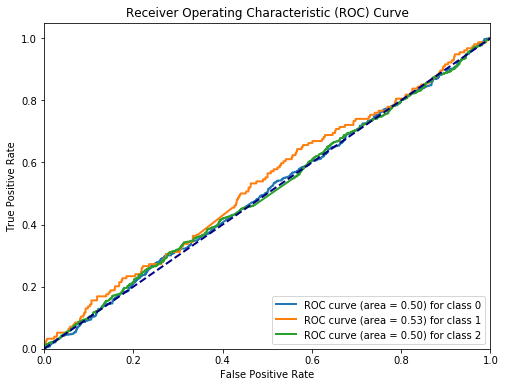

In [35]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()